In [8]:
# Import required libraries for model building
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from minio import Minio
from utils.config import MINIO_ENDPOINT, MINIO_SECURE

def get_minio_client() -> Minio:
    """Initialize and return a MinIO client."""
    return Minio(
        endpoint=MINIO_ENDPOINT,
        access_key=os.getenv("MINIO_ACCESS_KEY"),
        secret_key=os.getenv("MINIO_SECRET_KEY"),
        session_token=os.getenv("MINIO_SESSION_TOKEN"),
        secure=MINIO_SECURE
    )


client = get_minio_client()


In [2]:
def load_image_dataset(data_directory):
    """
    Load image dataset and prepare it for model training, separating train and test sets
    based on filename convention:
    - Train images: img_<number_id>.png
    - Test images: test_img_<number_id>.png
    
    Args:
        data_directory: Directory containing the dataset
    
    Returns:
        Tuple containing (X_train, y_train, X_test, y_test)
    """
    import os
    import numpy as np
    from PIL import Image
    
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    
    class_dirs = sorted([d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))])
    
    # Create a mapping from class names to indices
    class_to_idx = {class_name: i for i, class_name in enumerate(class_dirs)}
    
    # Print class mapping for reference
    print("Class mapping:")
    for class_name, idx in class_to_idx.items():
        print(f"  {idx}: {class_name}")
    
    # Load images and labels
    for class_dir in class_dirs:
        class_path = os.path.join(data_directory, class_dir)
        class_idx = class_to_idx[class_dir]
        
        train_count = 0
        test_count = 0
        
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                image_path = os.path.join(class_path, image_file)
                try:
                    img = Image.open(image_path).convert('RGB')
                    # Convert image to numpy array and normalize (adjust as needed)
                    img_array = np.array(img) / 255.0
                    
                    # Determine if this is a train or test image based on filename
                    if image_file.startswith('test_img_'):
                        test_images.append(img_array)
                        test_labels.append(class_idx)
                        test_count += 1
                    else:
                        train_images.append(img_array)
                        train_labels.append(class_idx)
                        train_count += 1
                        
                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
        
        print(f"Class {class_idx} ({class_dir}): {train_count} training images, {test_count} test images")
    
    # Convert to numpy arrays
    X_train = np.array(train_images)
    y_train = np.array(train_labels)
    X_test = np.array(test_images)
    y_test = np.array(test_labels)
    
    print(f"Total dataset: {len(X_train)} training images, {len(X_test)} test images")
    print(f"Number of classes: {len(np.unique(y_train))}")
    
    return X_train, y_train, X_test, y_test

In [3]:
local_download_path = "./downloaded_data"

X_train, y_train, X_test, y_test = load_image_dataset(local_download_path)

Class mapping:
  0: class_0_adipose
  1: class_1_background
  2: class_2_debris
  3: class_3_lymphocytes
  4: class_4_mucus
  5: class_5_smooth_muscle
  6: class_6_normal_colon_mucosa
  7: class_7_cancer-associated_stroma
  8: class_8_colorectal_adenocarcinoma_epithelium
Class 0 (class_0_adipose): 56 training images, 26 test images
Class 1 (class_1_background): 56 training images, 8 test images
Class 2 (class_2_debris): 52 training images, 5 test images
Class 3 (class_3_lymphocytes): 70 training images, 9 test images
Class 4 (class_4_mucus): 38 training images, 15 test images
Class 5 (class_5_smooth_muscle): 80 training images, 5 test images
Class 6 (class_6_normal_colon_mucosa): 36 training images, 11 test images
Class 7 (class_7_cancer-associated_stroma): 48 training images, 5 test images
Class 8 (class_8_colorectal_adenocarcinoma_epithelium): 65 training images, 16 test images
Total dataset: 501 training images, 100 test images
Number of classes: 9


In [4]:

# Check data shape
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Convert labels to categorical format for multi-class classification
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

X_train shape: (501, 224, 224, 3)
X_test shape: (100, 224, 224, 3)
Number of classes: 9


In [5]:
# Define a CNN model architecture
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and fully connected layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Get input shape from training data
input_shape = X_train.shape[1:]
print(f"Input shape: {input_shape}")

# Create and compile model
model = create_cnn_model(input_shape, num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Input shape: (224, 224, 3)


/home/george/.cache/pypoetry/virtualenvs/humaine-swarm-IeHX0o3Z-py3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1743200205.955884  327767 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743200205.970421  327767 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devic

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,982,505 (99.12 MB)

 Trainable params: 25,981,097 (99.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [6]:
# Set up callbacks for training
checkpoint_filepath = './model_checkpoints/best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # Using 20% of training data for validation
    callbacks=[model_checkpoint, early_stopping],
    verbose=1
)

Epoch 1/50


2025-03-29 00:17:28.551710: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 240844800 exceeds 10% of free system memory.
2025-03-29 00:17:30.851119: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-03-29 00:17:30.899047: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-03-29 00:17:30.951846: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-03-29 00:17:30.992682: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3971 - loss: 2.2709
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to ./model_checkpoints/best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.4035 - loss: 2.2412 - val_accuracy: 0.0000e+00 - val_loss: 8.4592
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6207 - loss: 1.1253
Epoch 2: val_accuracy did not improve from 0.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6213 - loss: 1.1264 - val_accuracy: 0.0000e+00 - val_loss: 4.3416
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6870 - loss: 0.9822
Epoch 3: val_accuracy improved from 0.00000 to 0.35644, saving model to ./model_checkpoints/best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6853 - loss: 0.9852 - val_accuracy: 0.3564 - val_loss: 5.7375
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7187 - loss: 0.8521
Epoch 4: val_accuracy did not improve from 0.35644
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7174 - loss: 0.8557 - val_accuracy: 0.0000e+00 - val_loss: 4.7746
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7286 - loss: 0.7491
Epoch 5: val_accuracy did not improve from 0.35644
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7296 - loss: 0.7503 - val_accuracy: 0.0000e+00 - val_loss: 5.6288
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7470 - loss: 0.7346
Epoch 6: val_accuracy did not improve from 0.35644
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7471 - loss: 0.7366 - val_accuracy: 0.0000e+00 - val_loss: 2.4022
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8441 - loss: 0.5177
Epoch 7: val_accuracy did not improve from 

13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7835 - loss: 0.6919 - val_accuracy: 0.6436 - val_loss: 1.9394
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8144 - loss: 0.6248
Epoch 11: val_accuracy did not improve from 0.64356
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8155 - loss: 0.6180 - val_accuracy: 0.2475 - val_loss: 6.5714
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8592 - loss: 0.4092
Epoch 12: val_accuracy did not improve from 0.64356
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8608 - loss: 0.4043 - val_accuracy: 0.6436 - val_loss: 2.8138
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9334 - loss: 0.2287
Epoch 13: val_accuracy did not improve from 0.64356
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9319 - loss: 0.2306 - val_accuracy: 0.6436 - val_loss: 4.2952
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9238 - loss: 0.2932
Epoch 14: val_accuracy did not improve from 0.64

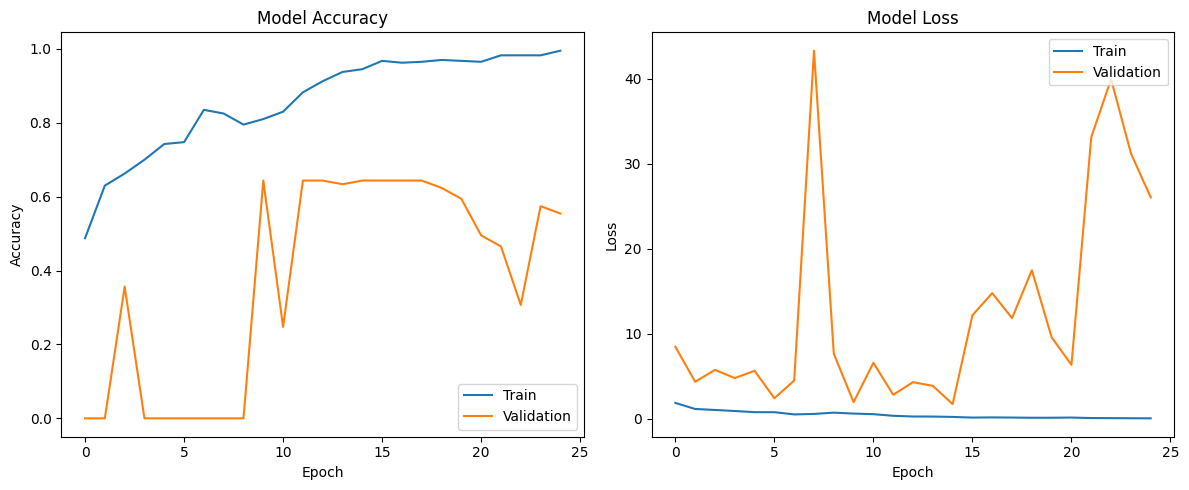

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get class names for better interpretability
class_dirs = sorted([d for d in os.listdir(local_download_path) if os.path.isdir(os.path.join(local_download_path, d))])
class_names = [name.replace('class_', '').replace('_', ' ') for name in class_dirs]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.1043 - loss: 17.3529  
Test accuracy: 0.1800
Test loss: 15.8709
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step

Classification Report:
                                        precision    recall  f1-score   support

                             0 adipose       0.00      0.00      0.00        26
                          1 background       0.00      0.00      0.00         8
                              2 debris       0.00      0.00      0.00         5
                         3 lymphocytes       0.00      0.00      0.00         9
                               4 mucus       0.00      0.00      0.00        15
                       5 smooth muscle       0.29      0.40      0.33         5
                 6 normal colon mucosa       0.00      0.00      0.00        11
            7 cancer-associated stroma       0.00      0.00      0.00         5
8 colorectal adenocarcinoma epithelium       0.17      1.00      0.30        16

                  

/home/george/.cache/pypoetry/virtualenvs/humaine-swarm-IeHX0o3Z-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/george/.cache/pypoetry/virtualenvs/humaine-swarm-IeHX0o3Z-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/george/.cache/pypoetry/virtualenvs/humaine-swarm-IeHX0o3Z-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

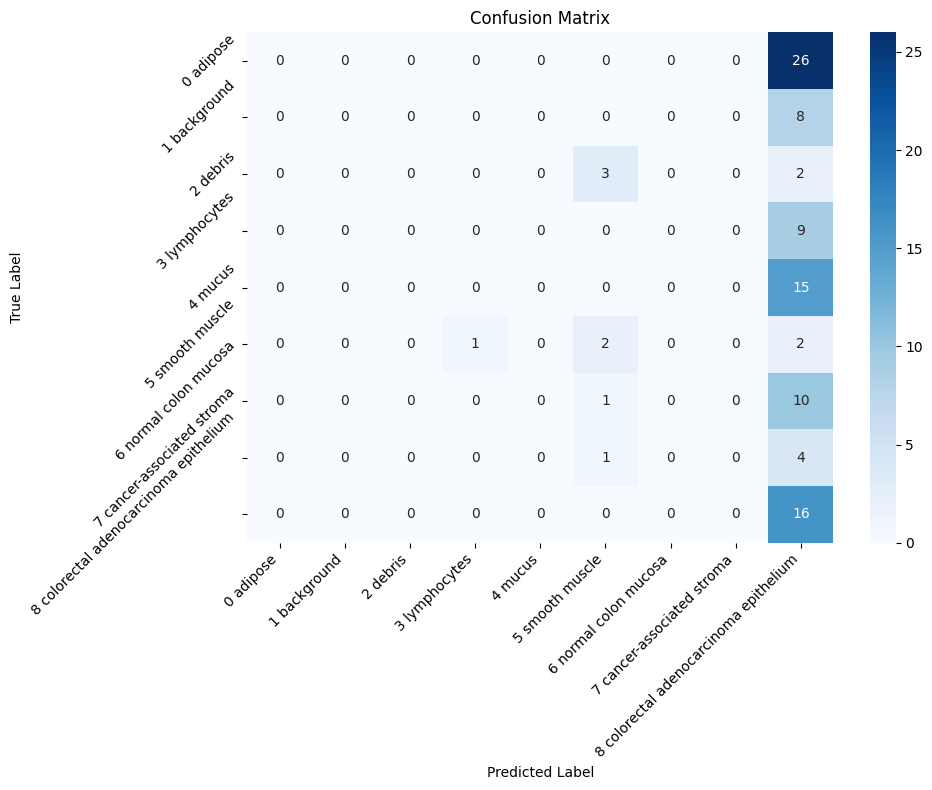

In [11]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Function to save the model and make it ready for deployment
def save_model_for_deployment(model, model_path, class_names):
    """
    Save the model and class names for deployment
    
    Args:
        model: Trained Keras model
        model_path: Directory to save the model
        class_names: List of class names
    """
    # Create directory if it doesn't exist
    os.makedirs(model_path, exist_ok=True)
    
    # Save the model using the newer .keras format
    model.save(os.path.join(model_path, 'model.keras'))
    
    # Save class names
    with open(os.path.join(model_path, 'class_names.txt'), 'w') as f:
        for name in class_names:
            f.write(f"{name}\n")
    
    # Save a model summary text file
    with open(os.path.join(model_path, 'model_summary.txt'), 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    print(f"Model and metadata saved to {model_path}")

In [13]:
# Function to upload model to MinIO
def upload_model_to_minio(client, local_model_path, bucket_name, minio_model_path):
    """
    Upload the model and related files to MinIO
    
    Args:
        client: MinIO client instance
        local_model_path: Path to the local directory containing the model files
        bucket_name: Name of the MinIO bucket
        minio_model_path: Path in MinIO where model should be stored
    """
    if not os.path.exists(local_model_path):
        print(f"Local model path {local_model_path} does not exist")
        return False
    
    # Check if bucket exists, create if it doesn't
    try:
        if not client.bucket_exists(bucket_name):
            client.make_bucket(bucket_name)
            print(f"Bucket '{bucket_name}' created")
    except Exception as e:
        print(f"Error creating bucket: {e}")
        return False
    
    # Upload all files in the model directory
    for root, dirs, files in os.walk(local_model_path):
        for file in files:
            local_file_path = os.path.join(root, file)
            # Calculate relative path to maintain directory structure
            rel_path = os.path.relpath(local_file_path, local_model_path)
            minio_file_path = os.path.join(minio_model_path, rel_path).replace('\\', '/')
            
            print(f"Uploading {local_file_path} to {bucket_name}/{minio_file_path}")
            
            try:
                # Upload the file to MinIO
                client.fput_object(
                    bucket_name,
                    minio_file_path,
                    local_file_path
                )
            except Exception as e:
                print(f"Error uploading {local_file_path}: {e}")
                
    print(f"Model successfully uploaded to MinIO: {bucket_name}/{minio_model_path}")
    return True

In [14]:
# After training and evaluation, save the model locally and then upload to MinIO
model_path = './trained_model'

# Save the model locally first
save_model_for_deployment(model, model_path, class_names)


# Get MinIO client
minio_client = get_minio_client()

# Define MinIO storage details
bucket_name = "innov-test-bucket"
minio_model_path = "trained_models/medmnist_model"

# Upload the model to MinIO
upload_model_to_minio(minio_client, model_path, bucket_name, minio_model_path)

Model and metadata saved to ./trained_model
Uploading ./trained_model/model.keras to innov-test-bucket/trained_models/medmnist_model/model.keras
Uploading ./trained_model/model_summary.txt to innov-test-bucket/trained_models/medmnist_model/model_summary.txt
Uploading ./trained_model/class_names.txt to innov-test-bucket/trained_models/medmnist_model/class_names.txt
Model successfully uploaded to MinIO: innov-test-bucket/trained_models/medmnist_model


True